In [ ]:
# Get helper functions file
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

# Import helper functions we're going to use
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir, compare_historys

--2026-02-12 08:48:01--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2026-02-12 08:48:01 (93.9 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


##Model 1

In [ ]:
import zipfile
zip_ref = zipfile.ZipFile('/gdrive/MyDrive/crop_data - filter_250126.zip','r')
zip_ref.extractall('dataset')
zip_ref.close()

In [ ]:
!pip install split-folders

In [ ]:
import tensorflow as tf
import splitfolders
import os

# 1. Cấu hình chung
SEED = 42
BATCH_SIZE = 32
IMAGE_SIZE = (224, 224)
tf.keras.utils.set_random_seed(SEED)

# Đường dẫn gốc và đường dẫn đích sau khi chia
input_folder = '/content/dataset/crop_data - filter_250126/crop_data'
output_folder = 'data_final'

# 2. Chia thư mục vật lý (Stratified Split)
# Chia theo tỷ lệ 80% Train, 20% Val (Test) cho TỪNG LỚP MỘT
splitfolders.ratio(input_folder,
                   output=output_folder,
                   seed=SEED,
                   ratio=(.8, .2),
                   move=False) # move=False để copy, tránh mất dữ liệu gốc

# 3. Load tập TRAIN từ thư mục mới
train_data = tf.keras.preprocessing.image_dataset_from_directory(
    directory=os.path.join(output_folder, 'train'),
    label_mode='int',
    batch_size=BATCH_SIZE,
    image_size=IMAGE_SIZE,
    shuffle=True,
    seed=SEED
)

# 4. Load tập TEST (Validation) từ thư mục mới
test_data = tf.keras.preprocessing.image_dataset_from_directory(
    directory=os.path.join(output_folder, 'val'),
    label_mode='int',
    batch_size=BATCH_SIZE,
    image_size=IMAGE_SIZE,
    shuffle=False # Khi đã chia thư mục riêng, Test nên để False để đánh giá chuẩn
)

my_class_names = train_data.class_names
num_classes = len(my_class_names)

# 5. Tối ưu bộ nhớ
AUTOTUNE = tf.data.AUTOTUNE
# Giữ cache cho Train để tăng tốc các epoch sau
train_data = train_data.cache().prefetch(buffer_size=AUTOTUNE)
# Tập Test chỉ cần prefetch là đủ (để tiết kiệm RAM vì thường chỉ predict 1 lần)
test_data = test_data.prefetch(buffer_size=AUTOTUNE)

print(f"\nDanh sách {num_classes} lớp đã sẵn sàng!")

Copying files: 8925 files [00:11, 754.00 files/s] 


Found 7118 files belonging to 52 classes.
Found 1807 files belonging to 52 classes.

Danh sách 52 lớp đã sẵn sàng!


In [ ]:
checkpoint_path ='model_checkpoint/checkpoint.weights.h5'
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                         monitor='val_loss',# save the model weights which score the best validation loss
                                                         save_weights_only=True,
                                                         save_best_only=True
                                                         )
# Setup EarlyStopping callback to stop training if model's val_loss doesn't improve for 2 epochs
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", # watch the val loss metric
                                                  patience=3)
# Creating learning rate reduction callback
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                                 factor=0.2, # multiply the learning rate by 0.2 (reduce by 5x)
                                                 patience=2,
                                                 verbose=1, # print out when learning rate goes down
                                                 min_lr=1e-7)

In [ ]:
from tensorflow import keras

data_augmentation = keras.Sequential([
    keras.layers.RandomFlip(mode='horizontal_and_vertical'),
    keras.layers.RandomRotation(0.2),
    keras.layers.RandomContrast(0.1),
    keras.layers.RandomBrightness(0.1)
])

In [ ]:
base_model = keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False)
base_model.trainable = False
inputs = keras.Input(shape=(224,224,3),name='input_layer')
x = data_augmentation(inputs)
x = base_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D(name='global_average_pooling')(x)
x = keras.layers.Dropout(0.2)(x)
outputs = keras.layers.Dense((num_classes), activation='softmax', name='output_layer')(x)
model = keras.Model(inputs, outputs)

24274472/24274472 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [ ]:
model.compile(optimizer=keras.optimizers.Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history = model.fit(train_data,
                    validation_data=test_data,
                    epochs=20,
                    callbacks=[checkpoint_callback
                               ])

Epoch 1/20
223/223 ━━━━━━━━━━━━━━━━━━━━ 41s 109ms/step - accuracy: 0.3727 - loss: 2.6345 - val_accuracy: 0.6331 - val_loss: 1.4395
Epoch 2/20
223/223 ━━━━━━━━━━━━━━━━━━━━ 24s 107ms/step - accuracy: 0.7447 - loss: 1.1096 - val_accuracy: 0.7737 - val_loss: 1.0322
Epoch 3/20
223/223 ━━━━━━━━━━━━━━━━━━━━ 41s 107ms/step - accuracy: 0.8089 - loss: 0.8035 - val_accuracy: 0.7886 - val_loss: 0.8564
Epoch 4/20
223/223 ━━━━━━━━━━━━━━━━━━━━ 20s 90ms/step - accuracy: 0.8401 - loss: 0.6618 - val_accuracy: 0.8124 - val_loss: 0.7499
Epoch 5/20
223/223 ━━━━━━━━━━━━━━━━━━━━ 19s 84ms/step - accuracy: 0.8554 - loss: 0.5868 - val_accuracy: 0.8340 - val_loss: 0.6619
Epoch 6/20
223/223 ━━━━━━━━━━━━━━━━━━━━ 20s 91ms/step - accuracy: 0.8646 - loss: 0.5392 - val_accuracy: 0.8500 - val_loss: 0.6003
Epoch 7/20
223/223 ━━━━━━━━━━━━━━━━━━━━ 19s 84ms/step - accuracy: 0.8841 - loss: 0.4742 - val_accuracy: 0.8572 - val_loss: 0.5698
Epoch 8/20
223/223 ━━━━━━━━━━━━━━━━━━━━ 20s 91ms/step - accuracy: 0.8815 - loss: 0.4544

In [ ]:
test_loss, test_acc = model.evaluate(test_data)
print(f'Test loss: {test_loss}')
print(f'Tess accuracy: {test_acc}')

57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 94ms/step - accuracy: 0.9012 - loss: 0.3440
Test loss: 0.3674117922782898
Tess accuracy: 0.8931931257247925


In [ ]:
for layer in base_model.layers[-20:]:
  layer.trainable = True

In [ ]:
model.compile(loss='sparse_categorical_crossentropy', optimizer=keras.optimizers.Adam(1e-4), metrics=['accuracy'])

In [ ]:
fine_tune_epochs = 50
history_fine_tune = model.fit(train_data,
          validation_data=test_data,
          epochs=fine_tune_epochs,
          initial_epoch=history.epoch[-1],
          callbacks=[checkpoint_callback,
                     early_stopping,
                     reduce_lr])


Epoch 20/50
223/223 ━━━━━━━━━━━━━━━━━━━━ 39s 109ms/step - accuracy: 0.8748 - loss: 0.4636 - val_accuracy: 0.9037 - val_loss: 0.3162 - learning_rate: 1.0000e-04
Epoch 21/50
223/223 ━━━━━━━━━━━━━━━━━━━━ 37s 95ms/step - accuracy: 0.9200 - loss: 0.2997 - val_accuracy: 0.9164 - val_loss: 0.2753 - learning_rate: 1.0000e-04
Epoch 22/50
223/223 ━━━━━━━━━━━━━━━━━━━━ 26s 116ms/step - accuracy: 0.9280 - loss: 0.2678 - val_accuracy: 0.9175 - val_loss: 0.2644 - learning_rate: 1.0000e-04
Epoch 23/50
223/223 ━━━━━━━━━━━━━━━━━━━━ 23s 101ms/step - accuracy: 0.9302 - loss: 0.2425 - val_accuracy: 0.9247 - val_loss: 0.2481 - learning_rate: 1.0000e-04
Epoch 24/50
223/223 ━━━━━━━━━━━━━━━━━━━━ 21s 95ms/step - accuracy: 0.9447 - loss: 0.2044 - val_accuracy: 0.9236 - val_loss: 0.2442 - learning_rate: 1.0000e-04
Epoch 25/50
223/223 ━━━━━━━━━━━━━━━━━━━━ 22s 101ms/step - accuracy: 0.9455 - loss: 0.1983 - val_accuracy: 0.9253 - val_loss: 0.2318 - learning_rate: 1.0000e-04
Epoch 26/50
223/223 ━━━━━━━━━━━━━━━━━━━━ 2

In [ ]:
test_loss_fine_tune, test_acc_fine_tune = model.evaluate(test_data)
print(f'Test loss after fine tuning: {test_loss_fine_tune}')
print(f'Tess accuracy after fine tuning: {test_acc_fine_tune}')

57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 92ms/step - accuracy: 0.9448 - loss: 0.1711
Test loss after fine tuning: 0.1867685765028
Tess accuracy after fine tuning: 0.9418926239013672


In [ ]:
model.save('/gdrive/MyDrive/Model.keras' )

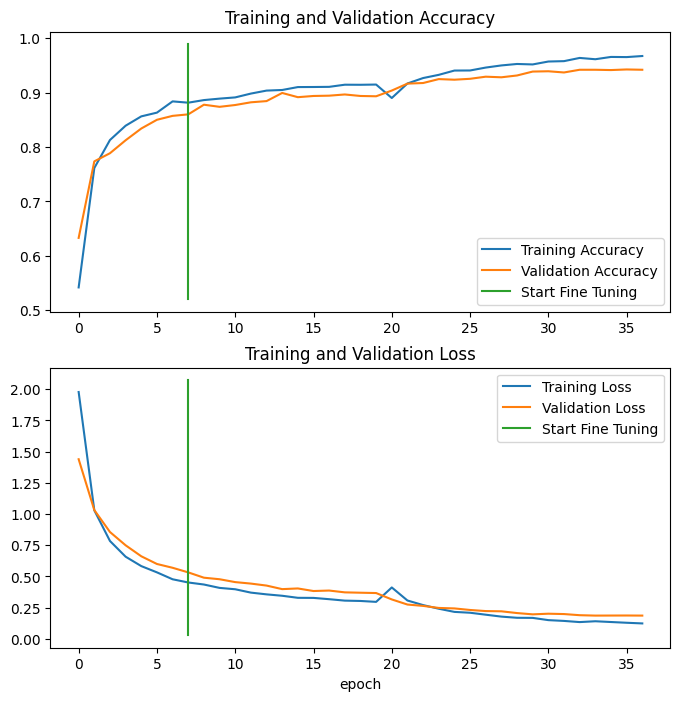

In [ ]:
compare_historys(original_history=history,
                 new_history=history_fine_tune, initial_epochs=8)

In [ ]:
pred_probs = model.predict(test_data, verbose=1)

# Get the class predictions of each label
pred_classes = pred_probs.argmax(axis=1)

y_labels = []
for images, labels in test_data.unbatch():
  y_labels.append(labels.numpy())


57/57 ━━━━━━━━━━━━━━━━━━━━ 11s 136ms/step


In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_labels, pred_classes))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        29
           1       0.78      0.87      0.82        45
           2       0.93      0.95      0.94        39
           3       0.95      0.97      0.96        39
           4       1.00      0.97      0.99        38
           5       0.82      0.92      0.87        36
           6       0.97      0.97      0.97        40
           7       1.00      0.94      0.97        34
           8       1.00      0.99      0.99        90
           9       0.92      0.92      0.92        13
          10       0.96      0.98      0.97        51
          11       0.96      1.00      0.98        50
          12       0.94      0.94      0.94        35
          13       0.76      0.76      0.76        38
          14       1.00      0.98      0.99        43
          15       0.93      0.87      0.90        15
          16       0.98      1.00      0.99        42
          17       1.00    

In [ ]:
import tensorflow as tf

model = tf.keras.models.load_model('/gdrive/MyDrive/Model.keras')

##Model 2

In [ ]:
import zipfile
zip_ref = zipfile.ZipFile('/gdrive/MyDrive/crop_data_dongvan.zip','r')
zip_ref.extractall('dataset')
zip_ref.close()

In [ ]:
import os
import shutil
import random

# ĐƯỜNG DẪN MỚI
path_moi = '/content/dataset/crop_data_dongvan - Copy'
path_test_moi_80 = '/content/dataset/test_moi_80'
path_train_moi_20 = '/content/dataset/train_moi_20' # Folder tạm cho 20% train

target_species = ['ager', 'bide']
random.seed(42)

for species in target_species:
    dir_nguon = os.path.join(path_moi, species)
    dir_dich_train = os.path.join(path_train_moi_20, species)
    dir_dich_test = os.path.join(path_test_moi_80, species)

    os.makedirs(dir_dich_train, exist_ok=True)
    os.makedirs(dir_dich_test, exist_ok=True)

    if os.path.exists(dir_nguon):
        files = [f for f in os.listdir(dir_nguon) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        random.shuffle(files)

        split_idx = int(len(files) * 0.2)
        train_files = files[:split_idx]
        test_files = files[split_idx:]

        print(f"Loài {species}: Train={len(train_files)}, Test={len(test_files)}")

        for f in train_files:
            shutil.copy(os.path.join(dir_nguon, f), os.path.join(dir_dich_train, f))
        for f in test_files:
            shutil.copy(os.path.join(dir_nguon, f), os.path.join(dir_dich_test, f))

print("--- Đã chia file vật lý xong ---")

Loài ager: Train=20, Test=83
Loài bide: Train=20, Test=80
--- Đã chia file vật lý xong ---


In [ ]:
# 1. Load 20% ảnh train mới từ folder tạm
ds_dongvan_20 = tf.keras.preprocessing.image_dataset_from_directory(
    '/content/dataset/train_moi_20',
    label_mode='int',
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE
)

# 2. Remap nhãn cho dữ liệu mới (ager=0, bide=7)
# Lưu ý: class_names của ds_dongvan_20 thường là ['ager', 'bide']
def remap_train_new(img, label):
    # ager là index 0 -> về 0; bide là index 1 -> về 7
    new_label = tf.where(tf.equal(label, 0), 0, 7)
    img = tf.cast(img, tf.float32)
    return img, new_label

ds_dongvan_20_final = ds_dongvan_20.map(remap_train_new)

# Load và xử lý 80% ảnh test mới
ds_test_80 = tf.keras.preprocessing.image_dataset_from_directory(
    '/content/dataset/test_moi_80',
    label_mode='int',
    image_size=IMAGE_SIZE,
    shuffle=False
)

class_names_test = tf.constant(ds_test_80.class_names)

def remap_test_final(img, label):
    name = tf.gather(class_names_test, label)
    new_label = tf.where(tf.equal(name, 'ager'), 0, 7)
    img = tf.cast(img, tf.float32)
    return img, new_label

final_test_ds = (ds_test_80.unbatch()
                 .map(remap_test_final)
                 .batch(BATCH_SIZE)
                 .prefetch(tf.data.AUTOTUNE))

Found 40 files belonging to 2 classes.
Found 163 files belonging to 2 classes.


In [ ]:
# Đánh giá
loss, acc = model.evaluate(final_test_ds)
print(f"Accuracy on 80% of new data: {acc*100:.2f}%")

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - accuracy: 0.3524 - loss: 1.7003
Accuracy on 80% of new data: 33.13%


In [ ]:
pred_probs = model.predict(final_test_ds, verbose=1)

# Get the class predictions of each label
pred_classes = pred_probs.argmax(axis=1)

y_labels = []
for images, labels in final_test_ds.unbatch():
  y_labels.append(labels.numpy())

class_names = my_class_names

6/6 ━━━━━━━━━━━━━━━━━━━━ 6s 514ms/step


In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_labels, pred_classes, labels=[0, 7]))

              precision    recall  f1-score   support

           0       0.78      0.37      0.50        83
           7       0.39      0.29      0.33        80

   micro avg       0.55      0.33      0.41       163
   macro avg       0.58      0.33      0.42       163
weighted avg       0.59      0.33      0.42       163



In [ ]:
import tensorflow as tf
import keras

linear_activation = keras.activations.get("linear")

student = tf.keras.models.load_model(
    "/gdrive/MyDrive/Model.keras",
    compile=False
)
student.get_layer("output_layer").activation = linear_activation


teacher = tf.keras.models.load_model(
    "/gdrive/MyDrive/Model.keras",
    compile=False
)
teacher.get_layer("output_layer").activation = linear_activation

teacher.trainable = False


In [ ]:
# 1. Hàm fix_shape (Giữ nguyên)
def fix_shape(x, y):
    x = tf.image.resize(x, [224, 224])
    x = tf.cast(x, tf.float32)
    x = tf.ensure_shape(x, [224, 224, 3])
    y = tf.cast(y, tf.int32)
    return x, y

# 2. Cách lấy Replay MỚI: Siêu nhanh, không dùng vòng lặp cho từng class
# Chúng ta lấy 1 lượng lớn ảnh cũ, xáo trộn 1 lần rồi lấy ra
# Đây là cách "Lazy Loading" chuẩn của TensorFlow
total_replay_samples = 52 * 24  # 1248 ảnh

replay_A = (
    train_data
    .unbatch()
    .shuffle(2000) # Trộn mạnh tay ngay từ đầu để đa dạng loài
    .take(total_replay_samples) # Lấy đủ số lượng cần thiết
    .map(fix_shape, num_parallel_calls=tf.data.AUTOTUNE)
)

# 3. Chuẩn bị train_new
train_new = (
    ds_dongvan_20_final
    .unbatch()
    .map(fix_shape, num_parallel_calls=tf.data.AUTOTUNE)
)

# 4. Gộp lại (Dùng weights để cân bằng 25/75)
train_CL = tf.data.Dataset.sample_from_datasets(
    [train_new.repeat(), replay_A.repeat()],
    weights=[0.25, 0.75],
    seed=42
)

# 5. Batch và Prefetch (Dùng Batch 32 để an toàn GPU)
train_CL = train_CL.batch(32, drop_remainder=True).prefetch(tf.data.AUTOTUNE)

print("Cấu hình Dataset thành công!")

Cấu hình Dataset thành công!


In [ ]:
import tensorflow as tf
import keras

class LogitsDistillation(keras.losses.Loss):
    def __init__(self, temperature=3.0, **kwargs):
        super().__init__(**kwargs)
        self.temperature = temperature

    def call(self, teacher_logits, student_logits):
        t = self.temperature
        teacher_probs = tf.nn.softmax(teacher_logits / t)
        student_log_probs = tf.nn.log_softmax(student_logits / t)

        # Cross-entropy phần KD * T^2
        kd_loss = -tf.reduce_sum(teacher_probs * student_log_probs, axis=1)
        return tf.reduce_mean(kd_loss) * (t ** 2)




In [ ]:

class FeatureDistillation(keras.losses.Loss):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.mse = keras.losses.MeanSquaredError()

    def call(self, teacher_feat, student_feat):
        # 1. Global Average Pooling nếu là 4D tensor
        if len(teacher_feat.shape) == 4:
            teacher_feat = tf.reduce_mean(teacher_feat, axis=[1, 2])
        if len(student_feat.shape) == 4:
            student_feat = tf.reduce_mean(student_feat, axis=[1, 2])

        # 2. L2 Normalize (Rất quan trọng để so sánh hướng vector)
        t_feat_norm = tf.nn.l2_normalize(teacher_feat, axis=-1)
        s_feat_norm = tf.nn.l2_normalize(student_feat, axis=-1)

        return self.mse(t_feat_norm, s_feat_norm)


In [ ]:
class Distiller(keras.Model):
    def __init__(
        self,
        teacher,
        student,
        layer_name_teacher, # Tên layer muốn lấy feature của Teacher
        layer_name_student, # Tên layer muốn lấy feature của Student
        lambda_kd=2.0,     # Hệ số tổng cho KD
        distill_weights=[0.6, 0.4], # [Weight Logits, Weight Feature]
        temperature=5.0,
        **kwargs
    ):
        super().__init__(**kwargs)
        self.teacher = teacher
        self.student = student
        self.lambda_kd = lambda_kd
        self.distill_weights = distill_weights
        self.temperature = temperature

        # Tạo extractor trả về [Logits, Features]
        self.teacher_extractor = self._make_extractor(teacher, layer_name_teacher)
        self.student_extractor = self._make_extractor(student, layer_name_student)

        # Loss functions
        self.student_loss_fn = keras.losses.SparseCategoricalCrossentropy(from_logits=True)
        self.logits_loss_fn = LogitsDistillation(temperature=temperature)
        self.feat_loss_fn = FeatureDistillation()

    def _make_extractor(self, model, layer_name):
        # Hàm này tạo một model giả, output ra 2 thứ: Logits và Feature layer
        try:
            output_layer = model.get_layer(layer_name).output
        except ValueError:
            print(f"⚠️ Cảnh báo: Không tìm thấy layer tên '{layer_name}'.")
            print("Các layer khả dụng cuối cùng:", [l.name for l in model.layers[-10:]])
            raise

        return keras.Model(
            inputs=model.input,
            outputs=[model.output, output_layer] # [Logits, Feature]
        )

    def compile(self, optimizer, metrics):
        super().compile(optimizer=optimizer, metrics=metrics)

    def train_step(self, data):
        x, y = data

        # 1. Forward Teacher (1 lần duy nhất)
        # Trả về tuple: (logits, features)
        t_logits, t_feat = self.teacher_extractor(x, training=False)

        with tf.GradientTape() as tape:
            # 2. Forward Student (1 lần duy nhất)
            s_logits, s_feat = self.student_extractor(x, training=True)

            # 3. Hard Loss (Ground Truth)
            loss_student = self.student_loss_fn(y, s_logits)

            # 4. Distillation Losses
            # a. Logits KD
            loss_logits = self.logits_loss_fn(t_logits, s_logits)

            # b. Feature KD
            loss_feat = self.feat_loss_fn(t_feat, s_feat)

            # 5. Tổng hợp Loss
            # Total = Hard + lambda * (w1*Logits + w2*Feature)
            w_logits, w_feat = self.distill_weights
            distill_total = (w_logits * loss_logits) + (w_feat * loss_feat)

            total_loss = loss_student + (self.lambda_kd * distill_total)

        # 6. Backprop
        grads = tape.gradient(total_loss, self.student.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.student.trainable_variables))

        # Update metrics
        self.compiled_metrics.update_state(y, s_logits)

        return {
            "loss": total_loss,
            "s_loss": loss_student,
            "kd_logits": loss_logits,
            "kd_feat": loss_feat
        }

    def test_step(self, data):
        x, y = data
        y_pred, _ = self.student_extractor(x, training=False)
        loss = self.student_loss_fn(y, y_pred)
        self.compiled_metrics.update_state(y, y_pred)
        results = {m.name: m.result() for m in self.metrics}
        results["loss"] = loss

        return results

In [ ]:
distiller = Distiller(
    teacher=teacher,
    student=student,
    layer_name_teacher="global_average_pooling",
    layer_name_student="global_average_pooling",
    lambda_kd=1.0,
    distill_weights=[0.5, 0.5],
    temperature=5.0
)

distiller.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5),
    metrics=['accuracy']
)


In [ ]:
distiller.fit(
    train_CL,
    epochs=5,
    steps_per_epoch = 52,
    validation_data=final_test_ds,
    )

Epoch 1/5


/usr/local/lib/python3.12/dist-packages/keras/src/backend/tensorflow/trainer.py:646: UserWarning: `model.compiled_metrics()` is deprecated. Instead, use e.g.:
```
for metric in self.metrics:
    metric.update_state(y, y_pred)
```

  return self._compiled_metrics_update_state(


52/52 ━━━━━━━━━━━━━━━━━━━━ 52s 385ms/step - kd_feat: 5.6370e-04 - kd_logits: 86.9799 - loss: 44.1360 - s_loss: 0.6457 - accuracy: 0.8282 - val_loss: 0.1262
Epoch 2/5
 1/52 ━━━━━━━━━━━━━━━━━━━━ 6s 125ms/step - kd_feat: 5.7023e-04 - kd_logits: 86.5971 - loss: 43.6546 - s_loss: 0.3557

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


52/52 ━━━━━━━━━━━━━━━━━━━━ 16s 313ms/step - kd_feat: 5.6636e-04 - kd_logits: 86.9503 - loss: 43.8499 - s_loss: 0.3745 - accuracy: 0.9387 - val_loss: 0.0451
Epoch 3/5
52/52 ━━━━━━━━━━━━━━━━━━━━ 20s 396ms/step - kd_feat: 5.6240e-04 - kd_logits: 86.5349 - loss: 43.5250 - s_loss: 0.2573 - accuracy: 0.9448 - val_loss: 0.0665
Epoch 4/5
52/52 ━━━━━━━━━━━━━━━━━━━━ 17s 332ms/step - kd_feat: 5.5442e-04 - kd_logits: 86.4513 - loss: 43.4482 - s_loss: 0.2223 - accuracy: 0.9571 - val_loss: 0.0422
Epoch 5/5
52/52 ━━━━━━━━━━━━━━━━━━━━ 22s 424ms/step - kd_feat: 5.5213e-04 - kd_logits: 86.6105 - loss: 43.5491 - s_loss: 0.2436 - accuracy: 0.9571 - val_loss: 0.0377


In [ ]:
student.save("/gdrive/MyDrive/Continual_model.keras")

In [ ]:
student_loaded = tf.keras.models.load_model("/gdrive/MyDrive/Continual_model.keras")

In [ ]:
student_loaded.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)
loss, acc = student_loaded.evaluate(final_test_ds)
print(f"Test loss: {loss:.4f}, Test accuracy on new data: {acc:.4f}")

6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 64ms/step - accuracy: 0.9655 - loss: 0.1505
Test loss: 0.1569, Test accuracy on new data: 0.9571


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


In [ ]:
loss, acc = student_loaded.evaluate(test_data)
print(f"Test loss: {loss:.4f}, Test accuracy on old data: {acc:.4f}")

57/57 ━━━━━━━━━━━━━━━━━━━━ 7s 127ms/step - accuracy: 0.9382 - loss: 0.1984
Test loss: 0.2142, Test accuracy on old data: 0.9303


In [ ]:
pred_probs = student_loaded.predict(test_data, verbose=1)

# Get the class predictions of each label
pred_classes = pred_probs.argmax(axis=1)

y_labels = []
for images, labels in test_data.unbatch():
  y_labels.append(labels.numpy())


from sklearn.metrics import classification_report
print(classification_report(y_labels, pred_classes))

57/57 ━━━━━━━━━━━━━━━━━━━━ 11s 157ms/step
              precision    recall  f1-score   support

           0       0.97      1.00      0.98        29
           1       0.78      0.84      0.81        45
           2       0.93      0.97      0.95        39
           3       0.95      0.97      0.96        39
           4       1.00      0.97      0.99        38
           5       0.85      0.92      0.88        36
           6       0.97      0.97      0.97        40
           7       0.97      0.94      0.96        34
           8       1.00      0.99      0.99        90
           9       0.92      0.85      0.88        13
          10       0.98      0.96      0.97        51
          11       0.94      1.00      0.97        50
          12       0.97      0.94      0.96        35
          13       0.71      0.76      0.73        38
          14       1.00      1.00      1.00        43
          15       0.87      0.87      0.87        15
          16       0.98      1.00      

In [ ]:
pred_probs = student_loaded.predict(final_test_ds, verbose=1)

# Get the class predictions of each label
pred_classes = pred_probs.argmax(axis=1)

y_labels = []
for images, labels in final_test_ds.unbatch():
  y_labels.append(labels.numpy())


from sklearn.metrics import classification_report
print(classification_report(y_labels, pred_classes, labels=[0, 7]))

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


              precision    recall  f1-score   support

           0       0.99      0.96      0.98        83
           7       0.96      0.95      0.96        80

   micro avg       0.97      0.96      0.97       163
   macro avg       0.97      0.96      0.97       163
weighted avg       0.98      0.96      0.97       163



##Model 3

In [ ]:
import os
import re
import unicodedata

def khong_dau(text):
    # Hàm chuyển Tiếng Việt có dấu thành không dấu
    text = unicodedata.normalize('NFD', text)
    text = re.sub(r'[\u0300-\u036f]', '', text)
    return text.lower()

path_data = '/content/dataset/crop_data_dongvan - Copy'
folders = os.listdir(path_data)

for folder_name in folders:
    # 1. Chuyển thành không dấu: "chro (cỏ hôi)" -> "chro (co hoi)"
    new_name = khong_dau(folder_name)
    # 2. Xóa ký tự đặc biệt và thay khoảng trắng bằng gạch dưới
    # Kết quả: "chro_co_hoi"
    new_name = re.sub(r'[^a-z0-9]+', '_', new_name).strip('_')

    old_path = os.path.join(path_data, folder_name)
    new_path = os.path.join(path_data, new_name)

    if old_path != new_path:
        os.rename(old_path, new_path)
        print(f"Đã đổi: '{folder_name}' -> '{new_name}'")

Đã đổi: 'ipom (bòi ngòi)' -> 'ipom_boi_ngoi'
Đã đổi: 'sige (nghệ đầu)' -> 'sige_nghe_au'
Đã đổi: 'chro (cỏ lào)' -> 'chro_co_lao'
Đã đổi: 'ruel (chiều tím)' -> 'ruel_chieu_tim'
Đã đổi: 'sige (hy thiêm)' -> 'sige_hy_thiem'
Đã đổi: 'ruel (chi mè đất)' -> 'ruel_chi_me_at'
Đã đổi: 'cler (bạc hà dại)' -> 'cler_bac_ha_dai'
Đã đổi: 'ipom (bìm biếc)' -> 'ipom_bim_biec'
Đã đổi: 'chro (cỏ hôi)' -> 'chro_co_hoi'
Đã đổi: 'cler (diếp đáng)' -> 'cler_diep_ang'
Đã đổi: 'ruel (bướm tím)' -> 'ruel_buom_tim'


In [ ]:
import os
import shutil
import random
import tensorflow as tf

# --- CẤU HÌNH ĐƯỜNG DẪN ---
path_moi = '/content/dataset/crop_data_dongvan - Copy'
path_test_20loai_80 = '/content/dataset/test_20loai_80'
path_train_20loai_20 = '/content/dataset/train_20loai_20'

# --- CẬP NHẬT DANH SÁCH 20 LOÀI ---
target_species = [
    'abel', 'bras', 'chro', 'chro_co_hoi', 'chro_co_lao', 'cler_bac_ha_dai', 'cler_diep_ang', 'clin', 'ipom_bim_biec', 'ipom_boi_ngoi',
    'leuc', 'ruel_buom_tim', 'ruel_chi_me_at', 'ruel_chieu_tim', 'sige_hy_thiem', 'sige_nghe_au', 'teco', 'tith', 'tore', 'trid'
]

random.seed(42)

# --- BƯỚC 1: CHIA FILE VẬT LÝ ---
for species in target_species:
    dir_nguon = os.path.join(path_moi, species)
    dir_dich_train = os.path.join(path_train_20loai_20, species)
    dir_dich_test = os.path.join(path_test_20loai_80, species)

    os.makedirs(dir_dich_train, exist_ok=True)
    os.makedirs(dir_dich_test, exist_ok=True)

    if os.path.exists(dir_nguon):
        files = [f for f in os.listdir(dir_nguon) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        if len(files) > 0:
            random.shuffle(files)
            split_idx = int(len(files) * 0.2)
            train_files = files[:split_idx]
            test_files = files[split_idx:]

            for f in train_files:
                shutil.copy(os.path.join(dir_nguon, f), os.path.join(dir_dich_train, f))
            for f in test_files:
                shutil.copy(os.path.join(dir_nguon, f), os.path.join(dir_dich_test, f))
            print(f"Loài {species}: Train={len(train_files)}, Test={len(test_files)}")

print("--- Đã chia file vật lý xong ---")

# --- BƯỚC 2: TẠO BẢNG TRA CỨU NHÃN (52 -> 71) ---
# Nhãn sẽ bắt đầu từ 52 đến 71 (tổng 20 nhãn mới)
new_labels_values = list(range(52, 52 + len(target_species)))

table = tf.lookup.StaticHashTable(
    initializer=tf.lookup.KeyValueTensorInitializer(
        keys=tf.constant(target_species),
        values=tf.constant(new_labels_values, dtype=tf.int64)
    ),
    default_value=tf.constant(-1, dtype=tf.int64)
)

# --- BƯỚC 3: HÀM PREPARE DATASET (GIỮ NGUYÊN LOGIC) ---
def prepare_dataset(path, is_train=True):
    ds = tf.keras.preprocessing.image_dataset_from_directory(
        path,
        label_mode='int',
        image_size=(224, 224),
        batch_size=32,
        shuffle=is_train
    )

    names_list = ds.class_names
    class_names_tensor = tf.constant(names_list)

    def remap_fn(img, label):
        name = tf.gather(class_names_tensor, label)
        new_label = table.lookup(name)
        return tf.cast(img, tf.float32), new_label

    return ds.map(remap_fn).prefetch(tf.data.AUTOTUNE)

# --- BƯỚC 4: LOAD DATA ---
train_20_loai_final = prepare_dataset(path_train_20loai_20, is_train=True)
final_test_20 = prepare_dataset(path_test_20loai_80, is_train=False)

print(f"✅ Dataset đã sẵn sàng với nhãn từ 52 đến {52 + len(target_species) - 1}!")

Loài abel: Train=20, Test=81
Loài bras: Train=17, Test=71
Loài chro: Train=20, Test=81
Loài chro_co_hoi: Train=20, Test=82
Loài chro_co_lao: Train=19, Test=76
Loài cler_bac_ha_dai: Train=47, Test=191
Loài cler_diep_ang: Train=20, Test=81
Loài clin: Train=16, Test=65
Loài ipom_bim_biec: Train=26, Test=106
Loài ipom_boi_ngoi: Train=16, Test=68
Loài leuc: Train=16, Test=64
Loài ruel_buom_tim: Train=16, Test=66
Loài ruel_chi_me_at: Train=19, Test=79
Loài ruel_chieu_tim: Train=18, Test=73
Loài sige_hy_thiem: Train=17, Test=69
Loài sige_nghe_au: Train=20, Test=83
Loài teco: Train=20, Test=82
Loài tith: Train=21, Test=88
Loài tore: Train=15, Test=60
Loài trid: Train=17, Test=68
--- Đã chia file vật lý xong ---
Found 400 files belonging to 20 classes.
Found 1634 files belonging to 20 classes.
✅ Dataset đã sẵn sàng với nhãn từ 52 đến 71!


In [ ]:
# 1. Hàm fix_shape (Giữ nguyên)
def fix_shape(x, y):
    x = tf.image.resize(x, [224, 224])
    x = tf.cast(x, tf.float32)
    x = tf.ensure_shape(x, [224, 224, 3])
    y = tf.cast(y, tf.int32)
    return x, y

# 2. Cách lấy Replay MỚI: Siêu nhanh, không dùng vòng lặp cho từng class
# Chúng ta lấy 1 lượng lớn ảnh cũ, xáo trộn 1 lần rồi lấy ra
# Đây là cách "Lazy Loading" chuẩn của TensorFlow
total_replay_samples = 52 * 24  # 1248 ảnh

replay_A = (
    train_data
    .unbatch()
    .shuffle(2000) # Trộn mạnh tay ngay từ đầu để đa dạng loài
    .take(total_replay_samples) # Lấy đủ số lượng cần thiết
    .map(fix_shape, num_parallel_calls=tf.data.AUTOTUNE)
)

# 3. Chuẩn bị train_new
train_new = (
    train_20_loai_final
    .unbatch()
    .map(fix_shape, num_parallel_calls=tf.data.AUTOTUNE)
)

# 4. Gộp lại (Dùng weights để cân bằng 25/75)
train_CL = tf.data.Dataset.sample_from_datasets(
    [train_new.repeat(), replay_A.repeat()],
    weights=[0.25, 0.75],
    seed=42
)

# 5. Batch và Prefetch (Dùng Batch 32 để an toàn GPU)
train_CL = train_CL.batch(32, drop_remainder=True).prefetch(tf.data.AUTOTUNE)

print("Cấu hình Dataset thành công!")

Cấu hình Dataset thành công!


In [ ]:
import tensorflow as tf
from tensorflow import keras

# 1. LOAD TEACHER (Model 52 loài gốc - Làm bản gốc để lấy tri thức)
teacher = tf.keras.models.load_model('/gdrive/MyDrive/Continual_model.keras', compile=False)
teacher.trainable = False

# 2. XÂY DỰNG STUDENT (Model 72 loài)
# Lấy backbone từ teacher (trừ lớp Dense cuối)
backbone_output = teacher.layers[-2].output
# Tạo lớp đầu ra mới với 72 node, để activation=None (Linear) luôn từ đầu
new_predictions = tf.keras.layers.Dense(72, activation=None, name='new_predictions')(backbone_output)

student = tf.keras.models.Model(inputs=teacher.input, outputs=new_predictions)

# 3. PHẪU THUẬT TRỌNG SỐ (Weight Transplant)
# Lấy trọng số xịn từ Teacher
old_weights, old_biases = teacher.layers[-1].get_weights()

# Lấy trọng số khởi tạo của Student
new_layer = student.get_layer("new_predictions")
new_weights, new_biases = new_layer.get_weights()

# Chép 52 loài cũ vào 52 vị trí đầu
new_weights[:, :52] = old_weights
new_biases[:52] = old_biases

# Khóa 20 loài mới bằng cách ép Bias xuống cực thấp
new_biases[52:] = -10.0

# Nạp lại vào Student
new_layer.set_weights([new_weights, new_biases])

# 4. ĐỒNG BỘ HÓA ACTIVATION (Đảm bảo cả 2 đều là Linear cho Distillation)
teacher.layers[-1].activation = tf.keras.activations.linear
student.layers[-1].activation = tf.keras.activations.linear

print("--- Đã khôi phục tri thức 52 loài và chuẩn bị xong Student/Teacher! ---")

--- Đã khôi phục tri thức 52 loài và chuẩn bị xong Student/Teacher! ---


In [ ]:
def prepare_old_data_for_72_classes(image, label):
    # 1. Chuyển label sang One-hot (nếu chưa là one-hot)
    # Nếu label đã là [?, 52] thì tf.one_hot sẽ không lỗi nhưng tốt nhất nên check
    if len(label.shape) <= 1:
        label = tf.one_hot(tf.cast(label, tf.int32), depth=52)

    # 2. Lấy Batch Size hiện tại để tạo Padding tương ứng
    batch_size = tf.shape(label)[0]

    # 3. Tạo padding có shape [Batch_Size, 20]
    padding = tf.zeros([batch_size, 20], dtype=label.dtype)

    # 4. Ghép theo trục ngang (axis=1) để thành [Batch_Size, 61]
    new_label = tf.concat([label, padding], axis=1)

    return image, new_label

# Áp dụng vào dataset
test_data_padded = test_data.map(prepare_old_data_for_72_classes)

In [ ]:
# Đảm bảo model đã compile với from_logits=True vì lớp cuối đang là Linear
student.compile(
    optimizer='adam',
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

print("--- Đang đánh giá tập cũ (52 loài) trên Model Student mới (72 đầu ra) ---")
loss, acc = student.evaluate(test_data_padded)
print(f"\nAccuracy tập cũ khi chưa train: {acc*100:.2f}%")

--- Đang đánh giá tập cũ (52 loài) trên Model Student mới (72 đầu ra) ---
57/57 ━━━━━━━━━━━━━━━━━━━━ 19s 106ms/step - accuracy: 0.9382 - loss: 0.1984

Accuracy tập cũ khi chưa train: 93.03%


In [ ]:
class LogitsDistillation(keras.losses.Loss):
    def __init__(self, temperature=3.0, **kwargs):
        super().__init__(**kwargs)
        self.temperature = temperature

    def call(self, teacher_logits, student_logits):
        t = self.temperature

        # Lấy số lượng class của Teacher (ở đây là 52)
        num_teacher_classes = tf.shape(teacher_logits)[1]

        # CHỖ CẦN SỬA: Cắt student_logits để khớp với teacher_logits
        # Chúng ta chỉ so sánh phần kiến thức mà Teacher biết (52 loài cũ)
        student_logits_slice = student_logits[:, :num_teacher_classes]

        teacher_probs = tf.nn.softmax(teacher_logits / t)
        student_log_probs = tf.nn.log_softmax(student_logits_slice / t)

        # Cross-entropy phần KD * T^2
        kd_loss = -tf.reduce_sum(teacher_probs * student_log_probs, axis=1)
        return tf.reduce_mean(kd_loss) * (t ** 2)



In [ ]:

class FeatureDistillation(keras.losses.Loss):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.mse = keras.losses.MeanSquaredError()

    def call(self, teacher_feat, student_feat):
        # 1. Global Average Pooling nếu là 4D tensor
        if len(teacher_feat.shape) == 4:
            teacher_feat = tf.reduce_mean(teacher_feat, axis=[1, 2])
        if len(student_feat.shape) == 4:
            student_feat = tf.reduce_mean(student_feat, axis=[1, 2])

        # 2. L2 Normalize (Rất quan trọng để so sánh hướng vector)
        t_feat_norm = tf.nn.l2_normalize(teacher_feat, axis=-1)
        s_feat_norm = tf.nn.l2_normalize(student_feat, axis=-1)

        return self.mse(t_feat_norm, s_feat_norm)


In [ ]:
class Distiller(keras.Model):
    def __init__(
        self,
        teacher,
        student,
        layer_name_teacher, # Tên layer muốn lấy feature của Teacher
        layer_name_student, # Tên layer muốn lấy feature của Student
        lambda_kd=2.0,     # Hệ số tổng cho KD
        distill_weights=[0.6, 0.4], # [Weight Logits, Weight Feature]
        temperature=5.0,
        **kwargs
    ):
        super().__init__(**kwargs)
        self.teacher = teacher
        self.student = student
        self.lambda_kd = lambda_kd
        self.distill_weights = distill_weights
        self.temperature = temperature

        # Tạo extractor trả về [Logits, Features]
        self.teacher_extractor = self._make_extractor(teacher, layer_name_teacher)
        self.student_extractor = self._make_extractor(student, layer_name_student)

        # Loss functions
        self.student_loss_fn = keras.losses.SparseCategoricalCrossentropy(from_logits=True)
        self.logits_loss_fn = LogitsDistillation(temperature=temperature)
        self.feat_loss_fn = FeatureDistillation()

    def _make_extractor(self, model, layer_name):
        # Hàm này tạo một model giả, output ra 2 thứ: Logits và Feature layer
        try:
            output_layer = model.get_layer(layer_name).output
        except ValueError:
            print(f"⚠️ Cảnh báo: Không tìm thấy layer tên '{layer_name}'.")
            print("Các layer khả dụng cuối cùng:", [l.name for l in model.layers[-10:]])
            raise

        return keras.Model(
            inputs=model.input,
            outputs=[model.output, output_layer] # [Logits, Feature]
        )

    def compile(self, optimizer, metrics):
        super().compile(optimizer=optimizer, metrics=metrics)

    def train_step(self, data):
        x, y = data

        # 1. Forward Teacher (1 lần duy nhất)
        # Trả về tuple: (logits, features)
        t_logits, t_feat = self.teacher_extractor(x, training=False)

        with tf.GradientTape() as tape:
            # 2. Forward Student (1 lần duy nhất)
            s_logits, s_feat = self.student_extractor(x, training=True)

            # 3. Hard Loss (Ground Truth)
            loss_student = self.student_loss_fn(y, s_logits)

            # 4. Distillation Losses
            # a. Logits KD
            loss_logits = self.logits_loss_fn(t_logits, s_logits)

            # b. Feature KD
            loss_feat = self.feat_loss_fn(t_feat, s_feat)

            # 5. Tổng hợp Loss
            # Total = Hard + lambda * (w1*Logits + w2*Feature)
            w_logits, w_feat = self.distill_weights
            distill_total = (w_logits * loss_logits) + (w_feat * loss_feat*10000 )

            total_loss = loss_student + (self.lambda_kd * distill_total)

        # 6. Backprop
        grads = tape.gradient(total_loss, self.student.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.student.trainable_variables))

        # Update metrics
        self.compiled_metrics.update_state(y, s_logits)

        return {
            "loss": total_loss,
            "s_loss": loss_student,
            "kd_logits": loss_logits,
            "kd_feat": loss_feat*10000
        }

    def test_step(self, data):
        x, y = data
        y_pred, _ = self.student_extractor(x, training=False)
        loss = self.student_loss_fn(y, y_pred)
        self.compiled_metrics.update_state(y, y_pred)
        results = {m.name: m.result() for m in self.metrics}
        results["loss"] = loss

        return results

In [ ]:
distiller = Distiller(
    teacher=teacher,
    student=student,
    layer_name_teacher="global_average_pooling",
    layer_name_student="global_average_pooling",
    lambda_kd=2,
    distill_weights=[0.5, 0.5],
    temperature=3.0
)

distiller.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=4e-4),
    metrics=['accuracy']
)

In [ ]:
distiller.fit(
    train_CL,
    epochs=5,
    steps_per_epoch = 52,
    validation_data=final_test_20,
    )

Epoch 1/5


/usr/local/lib/python3.12/dist-packages/keras/src/backend/tensorflow/trainer.py:646: UserWarning: `model.compiled_metrics()` is deprecated. Instead, use e.g.:
```
for metric in self.metrics:
    metric.update_state(y, y_pred)
```

  return self._compiled_metrics_update_state(


52/52 ━━━━━━━━━━━━━━━━━━━━ 54s 513ms/step - kd_feat: 4.5705 - kd_logits: 20.1789 - loss: 28.6736 - s_loss: 3.9242 - accuracy: 0.0000e+00 - val_loss: 17.8410
Epoch 2/5
52/52 ━━━━━━━━━━━━━━━━━━━━ 20s 385ms/step - kd_feat: 3.8312 - kd_logits: 20.9375 - loss: 28.0681 - s_loss: 3.2994 - accuracy: 0.0863 - val_loss: 13.9090
Epoch 3/5
52/52 ━━━━━━━━━━━━━━━━━━━━ 23s 449ms/step - kd_feat: 3.1529 - kd_logits: 20.9055 - loss: 25.9825 - s_loss: 1.9240 - accuracy: 0.3146 - val_loss: 9.2097
Epoch 4/5
52/52 ━━━━━━━━━━━━━━━━━━━━ 19s 374ms/step - kd_feat: 2.7834 - kd_logits: 21.6271 - loss: 25.5549 - s_loss: 1.1444 - accuracy: 0.5526 - val_loss: 4.4872
Epoch 5/5
52/52 ━━━━━━━━━━━━━━━━━━━━ 22s 428ms/step - kd_feat: 2.5574 - kd_logits: 22.0385 - loss: 25.5119 - s_loss: 0.9160 - accuracy: 0.6151 - val_loss: 1.1720


In [ ]:
student.save("/gdrive/MyDrive/Continual_model2.keras")

In [ ]:
student2_loaded = tf.keras.models.load_model("/gdrive/MyDrive/Continual_model2.keras")

/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 38 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [ ]:
student2_loaded.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)
loss, acc = student2_loaded.evaluate(final_test_20)
print(f"Test loss: {loss:.4f}, Test accuracy: {acc:.4f}")

52/52 ━━━━━━━━━━━━━━━━━━━━ 10s 68ms/step - accuracy: 0.6085 - loss: 1.5341
Test loss: 1.4795, Test accuracy: 0.6151


In [ ]:
loss, acc = student2_loaded.evaluate(test_data)
print(f"Test loss: {loss:.4f}, Test accuracy: {acc:.4f}")

57/57 ━━━━━━━━━━━━━━━━━━━━ 11s 198ms/step - accuracy: 0.8424 - loss: 0.4734
Test loss: 0.5298, Test accuracy: 0.8373


In [ ]:
# Khởi tạo Distiller mới với Student cũ
distiller_stage2 = Distiller(
    student=student2_loaded,
    teacher=teacher,
    # Giữ nguyên các tham số cũ hoặc điều chỉnh nếu cần
    layer_name_teacher="global_average_pooling",
    layer_name_student="global_average_pooling",
    lambda_kd=2.0,           # Có thể tăng nhẹ nếu Acc cũ tụt
    distill_weights=[0.8, 0.2],
    temperature=6.0
)

distiller_stage2.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    metrics=['accuracy'],
)

In [ ]:
distiller_stage2.fit(
    train_CL,
    epochs=5,
    steps_per_epoch=52,
    validation_data=final_test_20,
)

Epoch 1/5


/usr/local/lib/python3.12/dist-packages/keras/src/backend/tensorflow/trainer.py:646: UserWarning: `model.compiled_metrics()` is deprecated. Instead, use e.g.:
```
for metric in self.metrics:
    metric.update_state(y, y_pred)
```

  return self._compiled_metrics_update_state(


52/52 ━━━━━━━━━━━━━━━━━━━━ 56s 491ms/step - kd_feat: 5.4305 - kd_logits: 129.9809 - loss: 210.8702 - s_loss: 0.7286 - accuracy: 0.6328 - val_loss: 1.8781
Epoch 2/5
52/52 ━━━━━━━━━━━━━━━━━━━━ 20s 387ms/step - kd_feat: 5.2069 - kd_logits: 129.4922 - loss: 209.9341 - s_loss: 0.6637 - accuracy: 0.6285 - val_loss: 1.9514
Epoch 3/5
52/52 ━━━━━━━━━━━━━━━━━━━━ 21s 411ms/step - kd_feat: 5.0204 - kd_logits: 129.0328 - loss: 209.0878 - s_loss: 0.6272 - accuracy: 0.6787 - val_loss: 1.8909
Epoch 4/5
52/52 ━━━━━━━━━━━━━━━━━━━━ 19s 378ms/step - kd_feat: 4.8686 - kd_logits: 128.8133 - loss: 208.5811 - s_loss: 0.5324 - accuracy: 0.6891 - val_loss: 1.5189
Epoch 5/5
52/52 ━━━━━━━━━━━━━━━━━━━━ 19s 366ms/step - kd_feat: 4.7942 - kd_logits: 129.1552 - loss: 209.1436 - s_loss: 0.5776 - accuracy: 0.6854 - val_loss: 1.7483


In [ ]:
student2_loaded.save("/gdrive/MyDrive/Continual_model3.keras")

In [ ]:
student3_loaded = tf.keras.models.load_model("/gdrive/MyDrive/Continual_model3.keras")

In [ ]:
student3_loaded.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)
loss, acc = student3_loaded.evaluate(final_test_20)
print(f"Test loss: {loss:.4f}, Test accuracy: {acc:.4f}")

52/52 ━━━━━━━━━━━━━━━━━━━━ 9s 70ms/step - accuracy: 0.7015 - loss: 1.0866
Test loss: 1.1641, Test accuracy: 0.6854


In [ ]:
loss, acc = student3_loaded.evaluate(test_data)
print(f"Test loss: {loss:.4f}, Test accuracy: {acc:.4f}")

57/57 ━━━━━━━━━━━━━━━━━━━━ 11s 138ms/step - accuracy: 0.9140 - loss: 0.2913
Test loss: 0.3014, Test accuracy: 0.9081


In [ ]:
# Khởi tạo Distiller mới với Student cũ
distiller_stage3 = Distiller(
    student=student3_loaded, # Model đã học 10 epoch
    teacher=teacher,
    # Giữ nguyên các tham số cũ hoặc điều chỉnh nếu cần
    layer_name_teacher="global_average_pooling",
    layer_name_student="global_average_pooling",
    lambda_kd=0.3,           # Có thể tăng nhẹ nếu Acc cũ tụt
    distill_weights=[0.8, 0.2],
    temperature=6.0
)

distiller_stage3.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    metrics=['accuracy'],
)

In [ ]:
distiller_stage3.fit(
    train_CL,
    epochs=4,
    steps_per_epoch=52,
    validation_data=final_test_20,
)

Epoch 1/4


/usr/local/lib/python3.12/dist-packages/keras/src/backend/tensorflow/trainer.py:646: UserWarning: `model.compiled_metrics()` is deprecated. Instead, use e.g.:
```
for metric in self.metrics:
    metric.update_state(y, y_pred)
```

  return self._compiled_metrics_update_state(


52/52 ━━━━━━━━━━━━━━━━━━━━ 56s 488ms/step - kd_feat: 4.7953 - kd_logits: 129.0598 - loss: 31.7384 - s_loss: 0.4763 - accuracy: 0.8042 - val_loss: 0.3820
Epoch 2/4
52/52 ━━━━━━━━━━━━━━━━━━━━ 20s 387ms/step - kd_feat: 4.8466 - kd_logits: 129.1382 - loss: 31.6593 - s_loss: 0.3753 - accuracy: 0.8146 - val_loss: 0.1624
Epoch 3/4
52/52 ━━━━━━━━━━━━━━━━━━━━ 20s 391ms/step - kd_feat: 4.8065 - kd_logits: 128.8420 - loss: 31.5582 - s_loss: 0.3477 - accuracy: 0.8421 - val_loss: 0.1200
Epoch 4/4
52/52 ━━━━━━━━━━━━━━━━━━━━ 24s 465ms/step - kd_feat: 4.7473 - kd_logits: 128.7080 - loss: 31.4680 - s_loss: 0.2932 - accuracy: 0.8580 - val_loss: 0.0956


In [ ]:
student3_loaded.save("/gdrive/MyDrive/Continual_model4.keras")

In [ ]:
student4_loaded = tf.keras.models.load_model("/gdrive/MyDrive/Continual_model4.keras")

In [ ]:
student4_loaded.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)
loss, acc = student4_loaded.evaluate(final_test_20)
print(f"Test loss: {loss:.4f}, Test accuracy on new data: {acc:.4f}")

52/52 ━━━━━━━━━━━━━━━━━━━━ 8s 67ms/step - accuracy: 0.8977 - loss: 0.4545
Test loss: 0.5336, Test accuracy on new data: 0.8715


In [ ]:
loss, acc = student4_loaded.evaluate(test_data)
print(f"Test loss: {loss:.4f}, Test accuracy on old data: {acc:.4f}")

57/57 ━━━━━━━━━━━━━━━━━━━━ 9s 89ms/step - accuracy: 0.9299 - loss: 0.2411
Test loss: 0.2541, Test accuracy on old data: 0.9236


In [ ]:
from sklearn.metrics import classification_report

pred_probs = student4_loaded.predict(final_test_20, verbose=1)
# Get the class predictions of each label
pred_classes = pred_probs.argmax(axis=1)

y_labels = []

for images, labels in final_test_20.unbatch():
  y_labels.append(labels.numpy())

# Danh sách ID: [52, 53, ..., 71]
new_species_labels = list(range(52, 72))

print("--- BÁO CÁO 20 LOÀI MỚI ---")

print(classification_report(y_labels, pred_classes, labels=new_species_labels))

52/52 ━━━━━━━━━━━━━━━━━━━━ 8s 120ms/step
--- BÁO CÁO 20 LOÀI MỚI ---
              precision    recall  f1-score   support

          52       1.00      0.99      0.99        81
          53       0.73      0.90      0.81        71
          54       0.99      0.84      0.91        81
          55       0.90      0.90      0.90        82
          56       0.97      0.87      0.92        76
          57       0.81      0.95      0.88       191
          58       0.99      0.94      0.96        81
          59       1.00      0.88      0.93        65
          60       1.00      1.00      1.00       106
          61       0.95      0.82      0.88        68
          62       0.80      0.50      0.62        64
          63       0.91      0.62      0.74        66
          64       0.81      0.82      0.82        79
          65       0.94      0.82      0.88        73
          66       0.89      0.83      0.86        69
          67       0.70      0.72      0.71        83
          68

In [ ]:
from sklearn.metrics import classification_report

pred_probs = student4_loaded.predict(test_data, verbose=1)
# Get the class predictions of each label
pred_classes = pred_probs.argmax(axis=1)

y_labels = []

for images, labels in test_data.unbatch():
  y_labels.append(labels.numpy())

# Danh sách ID: [52, 53, ..., 71]
new_species_labels = list(range(0, 52))

print("--- BÁO CÁO 52 LOÀI CŨ ---")

print(classification_report(y_labels, pred_classes, labels=new_species_labels))

57/57 ━━━━━━━━━━━━━━━━━━━━ 11s 157ms/step
--- BÁO CÁO 52 LOÀI CŨ ---
              precision    recall  f1-score   support

           0       0.97      1.00      0.98        29
           1       0.81      0.78      0.80        45
           2       0.81      1.00      0.90        39
           3       0.93      0.97      0.95        39
           4       0.95      0.92      0.93        38
           5       0.79      0.94      0.86        36
           6       0.97      0.97      0.97        40
           7       0.97      0.94      0.96        34
           8       1.00      1.00      1.00        90
           9       0.92      0.85      0.88        13
          10       0.93      0.98      0.95        51
          11       0.96      1.00      0.98        50
          12       1.00      0.80      0.89        35
          13       0.76      0.82      0.78        38
          14       1.00      0.95      0.98        43
          15       0.81      0.87      0.84        15
          16

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
